In [1]:
#######################################################################################
# Read Me Section:
## Name:
# Kaylen Smith Darnbrook
# Student ID:
# 2135667
# Course:
# M.S.c Machine Learning and Artificial Intelligence
# Module:
## FaceGeneration and Analysis:
## Description: 
# This module is responsible for creating the experimentation and creation of
# pipeline for the generation of faces using the Generative Accumulation Of Photons.
# The module will also be responsible for the analysis of the faces generated.
#####################################################################################

In [2]:
# Import Relevant Libraries:

# Import modules for system managment, io and file management 
import os 
import sys
import time 

# Import modules for data manipulation and analysis
import numpy as np
import pandas as pd
import scipy as sp

# Import modules for data visualisation
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from PIL import Image

# Import modules for Deep learning
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torchsummary
torch.set_float32_matmul_precision('medium')
from torchviz import make_dot

# Pytorch Lightning Modules:
import pytorch_lightning as pL
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks import LearningRateMonitor


# Import modules for model selection and evaluation.
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report


In [3]:
## Configuration
# Set the seed for reproducibility
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

# Set the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")
GREYSCALE = True

# Set the path to the data
root_path = r"C:\Users\kdarn\OneDrive\Documents\Life's Portfolio\Projects\GAPGalaxies\ffhq256"

Batch_Size = 32
load_pretained = False
NUM_Features = 128 * 128
EPOCHS = 100
learning_rate = 0.001
patience = 10

Device: cuda


In [4]:
def PSNR(original, transformed, max):
    mse = np.nan_to_num(np.mean((original - transformed) ** 2), 0)
    if mse == 0:
        return 100
    max_pixel = max
    psnr = 20 * np.log10(max_pixel / np.sqrt(mse))
    return psnr

def SSIM(original, transformed):
    return sp.signal.ssim(original, transformed, multichannel=True)

def Synthetic_PSNR(original, transformed, max):
    Poisson_Adjusted_MSE = np.nan_to_num(np.mean(((original - transformed)/np.sqrt(original))**2), 0)
    if Poisson_Adjusted_MSE == 0:
        return 100
    max_pixel = max
    psnr = 20 * np.log10(max_pixel / np.sqrt(Poisson_Adjusted_MSE))
    return psnr

In [5]:
class Image_Dataset:
    """"A blueprint responsible for creating the interface for downloading and converting the images into tensors"""
    def __init__(self, root_dir, transform=True, percentage = 1.0, mode = "Full", seed = 42, amplification_factor = 1e3):
        self.root_dir = root_dir
        self.transform = transform

        self.amplification_factor = amplification_factor
        self.images = os.listdir(root_dir)
        self.mode = mode 

        self.percentage = percentage
        self.Image_Names = [os.path.join(root_dir, img) for img in os.listdir(root_dir)]
        print(f"Number of Images: {len(self.images)}")
        self.Chosen_Image_Names = self.Image_Names[:int(len(self.images) * self.percentage)]
        print(f"Number of Chosen Images: {len(self.Chosen_Image_Names)}")
        #self.psnr_targets = {}

        train_indices, validation_indices = train_test_split(self.Chosen_Image_Names, test_size = 0.20, random_state = seed)
        self.train_indices = train_indices
        self.validation_indices = validation_indices

        if "training" in self.mode:
            self.Chosen_Image_Names = self.train_indices
        elif "validation" in self.mode:
            self.Chosen_Image_Names = self.validation_indices

    def __len__(self):
        """"Returns the length of the dataset"""
        return len(self.Chosen_Image_Names)

    def __lentrain__(self):
        return len(self.train_indices)

    def __lenvalid__(self):
        return len(self.validation_indices)
        
    def Generate_PSNR_Score(self, original, noisy, max_pixel):
        Mean_Squared_Error = torch.mean(torch.nan_to_num((((original - noisy)/np.sqrt(original))**2), nan = 0.0, posinf=0, neginf=0))
        if Mean_Squared_Error == 0:
            return 100.0
        psnr = 20 * torch.log10(max_pixel / torch.sqrt(Mean_Squared_Error))
        return psnr

    def generate_poisson_image(self, mean_counts):
        """Generate an initial Poisson distributed image."""
        initial_poisson_image = torch.poisson(mean_counts)
        psnr = self.Generate_PSNR_Score(mean_counts, initial_poisson_image, torch.max(mean_counts))
        return psnr, initial_poisson_image 

    def Generate_Target_PSNRs(self, index):
        """A method to generate the target PSNRs for the images"""
        image  = Image.open(os.path.join(self.root_dir, self.Chosen_Image_Names[index]))
        
        if GREYSCALE:
            image = image.convert('L')
        
        if self.transform:
            image = self.transform(image)
        
        image *= self.amplification_factor
        mean_counts = torch.round(image) 
        
        psnr = self.Generate_PSNR_Score(mean_counts, image, torch.max(mean_counts))
        max_psnr = psnr
        max_psnr = max_psnr.to(torch.int32)
        #if index not in self.psnr_targets:
            #self.psnr_targets[index] = torch.randint(low = 0, high = max_psnr, size = (1,))
            # return self.psnr_targets[index]
        #else:
            # return self.psnr_targets[index]
        return torch.randint(low = 0, high = max_psnr, size = (1,))
    
    def __getRawImage__(self, index):
        """A getter method to return the image at the specified index"""
        image = Image.open(os.path.join(self.root_dir, self.Chosen_Image_Names[index]))
        
        if GREYSCALE:
            image = image.convert('L')
        
        if self.transform:
            image = self.transform(image)

        return image
    
    def __getitem__(self, index):
        """A getter method used to return the image at a specified index in photon counts"""
        
        image  = Image.open(os.path.join(self.root_dir, self.Chosen_Image_Names[index]))
        
        if GREYSCALE:
            image = image.convert('L')
        
        if self.transform:
            image = self.transform(image)
        
        image *= self.amplification_factor
        mean_counts = torch.round(image) 
        
        psnr, _ = self.generate_poisson_image(mean_counts)

        max_psnr = torch.round(psnr)
        max_psnr = max_psnr.to(torch.int32)
        psnr_target = self.Generate_Target_PSNRs(index)
        #print(psnr_target)

        noise_factor = ((10 ** (psnr/10)) / (10 ** (psnr_target/10))) 

        Adjusted_Mean_Counts = mean_counts/noise_factor

        actual_psnr, Noisy_Image = self.generate_poisson_image(Adjusted_Mean_Counts)

        median = Noisy_Image.median()
        q75 = Noisy_Image.quantile(0.75)
        q25 = Noisy_Image.quantile(0.25)
        if not ( median == 0 or q75 == q25):
            Noisy_Image = (Noisy_Image - median)/torch.maximum(q75 - q25, torch.tensor([1e-1]))
        else:
            Noisy_Image = (Noisy_Image - Noisy_Image.min())/torch.maximum(Noisy_Image.max() - Noisy_Image.min(), torch.tensor([1e-1]))
        return Noisy_Image, actual_psnr

    def show_image(self, index):
        """A method to display the image at the specified index"""
        img = Image.open(os.path.join(self.root_dir, self.Chosen_Image_Names[index]))
        plt.imshow(img)
        plt.xlabel("X_Axis")
        plt.ylabel("Y_Axis")
        plt.show()
    
    def show_transformed_image(self, index):
        """A method to display the transformed image at the specified index"""
        img = Image.open(os.path.join(self.root_dir, self.Chosen_Image_Names[index]))
        if GREYSCALE:
            img = img.convert('L')

        img = self.transform(img)

        plt.imshow(img.permute(1, 2, 0), cmap = "gray")
        plt.xlabel("X_Axis")
        plt.ylabel("Y_Axis")
        plt.show()

class MinMaxNormalise(object):
    def __call__(self, tensor):
        """Performs the min-max normalisation on the tensor"""
        tensor = tensor.float()
        tensor = (tensor - tensor.min()) / (tensor.max() - tensor.min())
        return tensor
    
transform = transforms.Compose([
    transforms.PILToTensor(),
    transforms.ConvertImageDtype(torch.float32),
    transforms.CenterCrop((200, 200)),
    transforms.Resize((128, 128)),
    MinMaxNormalise(),
])

Train_Dataset = Image_Dataset(root_path, mode = "training", transform=transform)
Validation_Dataset = Image_Dataset(root_path, mode = "validation", transform=transform)
TrainLoader = DataLoader(Train_Dataset, batch_size = Batch_Size, shuffle = True)
ValidLoader = DataLoader(Validation_Dataset, batch_size = Batch_Size, shuffle = False)
Train_Dataset.__len__(), Validation_Dataset.__len__()

Number of Images: 70000
Number of Chosen Images: 70000
Number of Images: 70000
Number of Chosen Images: 70000


(56000, 14000)

In [21]:
iter(TrainLoader)

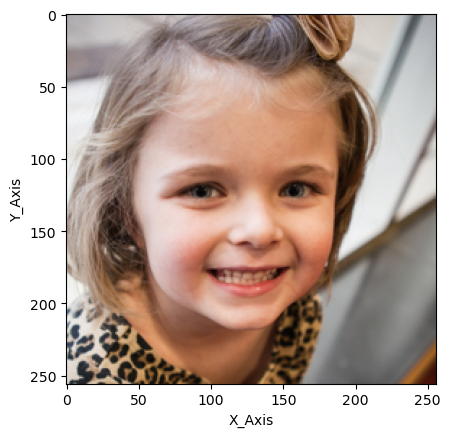

In [6]:
# Presents the untransformed image:
Train_Dataset.show_image(250)

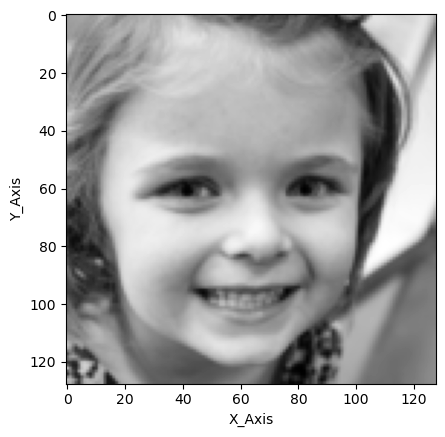

In [7]:
#Presents the transformed image:
Train_Dataset.show_transformed_image(250)

In [8]:
Img_250 = Train_Dataset.__getRawImage__(250)
torch.min(Img_250), torch.max(Img_250)

(tensor(0.), tensor(1.))

tensor(0.) tensor(0.2000) tensor(0.)
tensor(-3.8704) tensor(0.) tensor(1.)


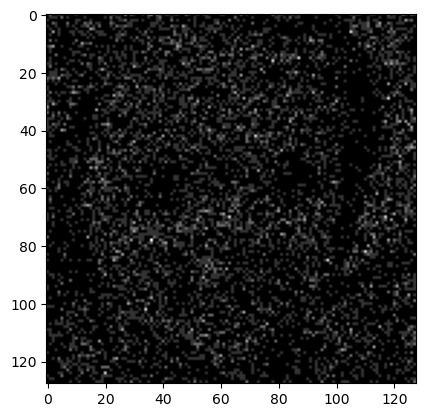

In [9]:
Noisy_Image, actual_psnr = Train_Dataset.__getitem__(250)
print(Noisy_Image.median(), Noisy_Image.quantile(0.75), Noisy_Image.quantile(0.25))
print(actual_psnr, torch.min(Noisy_Image), torch.max(Noisy_Image))
plt.imshow(Noisy_Image.permute(1, 2, 0), cmap = "gray")
plt.show()

In [10]:
def Negative_Log_Likelihood_Loss(predicted, target, sigma_values, alpha = 0.1, epilson = 1e-6):
    """A method to calculate the negative log likelihood loss for regression"""
    sigma_values = sigma_values.to(predicted.device)
    sigma_values = torch.clamp(sigma_values, min = 1e-6)
    sigma_values = sigma_values.view(-1, 1)
    predicted = predicted.view(-1, 1)
    target = target.view(-1, 1)
    loss = torch.log(sigma_values) + 0.5 * ((predicted - target) ** 2) / (sigma_values ** 2) + 0.5 * torch.log(torch.tensor([2 * np.pi]).to(predicted.device))
    loss = torch.mean(loss)
    return loss

In [11]:
class ResNet(pL.LightningModule):
    def __init__(self, learning_rate = 1e-3, in_channels = 1, num_targets = 1, out_features = 128, weight_decay = 1e-6, patience = 10, factor = 0.5, dropout_rate = 0.2):
        super(ResNet, self).__init__()

        # Define the Hyperparameters for the Network
        self.learning_rate = learning_rate
        self.in_channels = in_channels
        self.num_targets = num_targets
        self.out_features = out_features
        self.weight_decay = weight_decay
        self.patience = patience
        self.factor = factor
        self.dropout_rate = dropout_rate

        #self.BatchNorm0 = nn.BatchNorm2d(3)
        self.conv1a = nn.Conv2d(self.in_channels, 8, 3, padding = 1) # 64 x 64
        self.conv1b = nn.Conv2d(8, 16, 3, padding = 1)
        self.conv1c = nn.Conv2d(self.in_channels, 16, 1)

        self.MaxPool1 = nn.MaxPool2d(2, 2)
        self.BatchNorm1 = nn.BatchNorm2d(16)
        self.dropout = nn.Dropout(self.dropout_rate)
        self.activation = nn.LeakyReLU()

        self.conv2a = nn.Conv2d(16, 32, 3, padding = 1) # 32 x 32
        self.conv2b = nn.Conv2d(32, 64, 3, padding = 1) # 16 x 16
        self.conv2c = nn.Conv2d(16, 64, 1)

        self.MaxPool2 = nn.MaxPool2d(2, 2)
        self.BatchNorm2 = nn.BatchNorm2d(64)
        self.dropout_2 = nn.Dropout(self.dropout_rate)
        self.activation_2 = nn.LeakyReLU()

        self.conv3a = nn.Conv2d(64, 128, 3, padding = 1) # 16 x 16
        self.conv3b = nn.Conv2d(128, 128, 3, padding = 1)
        self.conv3c = nn.Conv2d(64, 128, 1)

        self.MaxPool3 = nn.MaxPool2d(2, 2)
        self.BatchNorm3 = nn.BatchNorm2d(128)
        self.dropout_3 = nn.Dropout(self.dropout_rate)
        self.activation_3 = nn.LeakyReLU()

        self.conv4a = nn.Conv2d(128, 256, 3, padding = 1) # 8 x 8
        self.conv4b = nn.Conv2d(256, 256, 3, padding = 1)
        self.conv4c = nn.Conv2d(128, 256, 1)
        self.MaxPool4 = nn.MaxPool2d(2, 2)
        self.BatchNorm4 = nn.BatchNorm2d(256)
        self.dropout_4 = nn.Dropout(self.dropout_rate)
        self.activation_4 = nn.LeakyReLU()

         # Define the Head of the Model
        self.Header = nn.ModuleList(
            [
                nn.LazyLinear(out_features = self.out_features*2),
                nn.GELU(),
                nn.LazyBatchNorm1d(),
                nn.Dropout(self.dropout_rate),

                nn.LazyLinear(out_features = self.out_features*2),
                nn.GELU(),
                nn.LazyBatchNorm1d(),
                nn.Dropout(self.dropout_rate),
            ]
        )
        
        # Define the output of the model
        self.Out_3a = nn.LazyLinear(out_features = self.num_targets)
        self.Out_3b = nn.LazyLinear(out_features = self.num_targets)
    
    def forward(self, x):

        x_skip = x
        x = self.BatchNorm1(self.activation(self.conv1b(self.conv1a(x_skip))))
        x_skip = self.conv1c(x_skip)
        x = torch.add(x, x_skip)
        #x = self.dropout(x)
        x = self.MaxPool1(x)

        x_skip = x
        x = self.BatchNorm2(self.activation_2(self.conv2b(self.conv2a(x))))
        x_skip = self.conv2c(x_skip)
        x = torch.add(x, x_skip)
        #x = self.dropout_2(x)
        x = self.MaxPool2(x)

        x_skip = x
        x = self.BatchNorm3(self.activation_3(self.conv3b(self.conv3a(x))))
        x_skip = self.conv3c(x_skip)
        x = torch.add(x, x_skip)
        x = self.dropout_3(self.MaxPool3(x))

        x_skip = x
        x = self.BatchNorm4(self.activation_4(self.conv4b(self.conv4a(x))))
        x_skip = self.conv4c(x_skip)
        x = torch.add(x, x_skip)
        #x = self.dropout_4(x)
        x = self.MaxPool4(x)
        
        x = x.view(x.size(0), -1)
        for layers in self.Header:
            #print(layers)
            x = layers(x)

        out_1 = self.Out_3a(x)
        out_2 = F.relu(self.Out_3b(x))
        out = torch.cat((out_1, out_2), dim = 1)
        return out
    
    def predict(self, x):
        output = self.forward(x)
        return output[:, :self.num_targets], output[:, self.num_targets:]
    
    def training_step(self, batch, batch_idx):
        x,y = batch
        x = x.to(device)
        y = y.to(device)

        predicted = self.forward(x)
        predicted_targets, predicted_uncertainties = predicted[:, :self.num_targets], predicted[:, self.num_targets:]
        NLL_Loss = Negative_Log_Likelihood_Loss(predicted_targets, y, predicted_uncertainties)
        self.log("Training_Loss", NLL_Loss, on_step = True, on_epoch = True, prog_bar = True, logger = True)
        return NLL_Loss
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        x = x.to(device)
        y = y.to(device)

        predicted = self.forward(x)
        predicted_targets, predicted_uncertainties = predicted[:, :self.num_targets], predicted[:, self.num_targets:]
        NLL_Loss = Negative_Log_Likelihood_Loss(predicted_targets, y, predicted_uncertainties)
        self.log("Validation_Loss", NLL_Loss, on_step = True, on_epoch = True, prog_bar = True, logger = True)
        return NLL_Loss
    
    def test_step(self, batch, batch_idx):
        x, y = batch
        x = x.to(device)
        y = y.to(device)

        predicted = self.forward(x)
        predicted_targets, predicted_uncertainties = predicted[:, :self.num_targets], predicted[:, self.num_targets:]
        NLL_Loss = Negative_Log_Likelihood_Loss(predicted_targets, y, predicted_uncertainties)
        self.log("Test_Loss", NLL_Loss, on_step = True, on_epoch = True, prog_bar = True, logger = True)
        return NLL_Loss
    
    def configure_optimizers(self):
        optimizer = torch.optim.NAdam(self.parameters(), lr = self.learning_rate, weight_decay=self.weight_decay)
        scheduler = {
            "scheduler":ReduceLROnPlateau(optimizer, mode = "min", factor = self.factor, patience = self.patience, verbose = True),
            "monitor":"Validation_Loss"
        }
        
        return [optimizer], [scheduler]
    
    def weights_init(self, m):
        if isinstance(m, nn.Conv2d):
            torch.nn.init.xavier_uniform_(m.weight)
            if m.bias is not None:
                torch.nn.init.zeros_(m.bias)
        if isinstance(m, nn.ConvTranspose2d):
            torch.nn.init.xavier_uniform_(m.weight)
            if m.bias is not None:
                torch.nn.init.zeros_(m.bias)
        if isinstance(m, nn.GroupNorm):
            torch.nn.init.zeros_(m.weight)
            torch.nn.init.zeros_(m.bias)
        if isinstance(m, nn.BatchNorm2d):
            torch.nn.init.zeros_(m.weight)
            torch.nn.init.zeros_(m.bias)

Residual_ConvNet = ResNet(
    in_channels = 1,
    num_targets = 1,
    out_features = 128,
    dropout_rate = 0.2,
    learning_rate = 0.001,
    weight_decay = 1e-6,
    factor = 0.1,
    patience = 10,

)
Residual_ConvNet = Residual_ConvNet.to(device)
# Print the summary of the model
torchsummary.summary(Residual_ConvNet, (1, 128, 128), device= device.type)

c:\Users\kdarn\anaconda3\envs\GAPGalaxy\Lib\site-packages\torch\nn\modules\lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 8, 128, 128]              80
            Conv2d-2         [-1, 16, 128, 128]           1,168
         LeakyReLU-3         [-1, 16, 128, 128]               0
       BatchNorm2d-4         [-1, 16, 128, 128]              32
            Conv2d-5         [-1, 16, 128, 128]              32
         MaxPool2d-6           [-1, 16, 64, 64]               0
            Conv2d-7           [-1, 32, 64, 64]           4,640
            Conv2d-8           [-1, 64, 64, 64]          18,496
         LeakyReLU-9           [-1, 64, 64, 64]               0
      BatchNorm2d-10           [-1, 64, 64, 64]             128
           Conv2d-11           [-1, 64, 64, 64]           1,088
        MaxPool2d-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 32, 32]          73,856
           Conv2d-14          [-1, 128,

In [12]:
class ResNet(pL.LightningModule):
    def __init__(self, learning_rate = 1e-3, in_channels = 1, num_targets = 1, out_features = 128, weight_decay = 1e-6, patience = 10, factor = 0.5, dropout_rate = 0.2):
        super(ResNet, self).__init__()

        # Define the Hyperparameters for the Network
        self.learning_rate = learning_rate
        self.in_channels = in_channels
        self.num_targets = num_targets
        self.out_features = out_features
        self.weight_decay = weight_decay
        self.patience = patience
        self.factor = factor
        self.dropout_rate = dropout_rate

        #self.BatchNorm0 = nn.BatchNorm2d(3)
        self.conv1a = nn.Conv2d(self.in_channels, 8, 3, padding = 1) # 64 x 64
        self.conv1b = nn.Conv2d(8, 16, 3, padding = 1)
        self.conv1c = nn.Conv2d(self.in_channels, 16, 1)

        self.MaxPool1 = nn.MaxPool2d(2, 2)
        self.BatchNorm1 = nn.BatchNorm2d(16)
        self.dropout = nn.Dropout(self.dropout_rate)
        self.activation = nn.LeakyReLU()

        self.conv2a = nn.Conv2d(16, 32, 3, padding = 1) # 32 x 32
        self.conv2b = nn.Conv2d(32, 64, 3, padding = 1) # 16 x 16
        self.conv2c = nn.Conv2d(16, 64, 1)

        self.MaxPool2 = nn.MaxPool2d(2, 2)
        self.BatchNorm2 = nn.BatchNorm2d(64)
        self.dropout_2 = nn.Dropout(self.dropout_rate)
        self.activation_2 = nn.LeakyReLU()

        self.conv3a = nn.Conv2d(64, 128, 3, padding = 1) # 16 x 16
        self.conv3b = nn.Conv2d(128, 128, 3, padding = 1)
        self.conv3c = nn.Conv2d(64, 128, 1)

        self.MaxPool3 = nn.MaxPool2d(2, 2)
        self.BatchNorm3 = nn.BatchNorm2d(128)
        self.dropout_3 = nn.Dropout(self.dropout_rate)
        self.activation_3 = nn.LeakyReLU()

        self.conv4a = nn.Conv2d(128, 256, 3, padding = 1) # 8 x 8
        self.conv4b = nn.Conv2d(256, 256, 3, padding = 1)
        self.conv4c = nn.Conv2d(128, 256, 1)
        self.MaxPool4 = nn.MaxPool2d(2, 2)
        self.BatchNorm4 = nn.BatchNorm2d(256)
        self.dropout_4 = nn.Dropout(self.dropout_rate)
        self.activation_4 = nn.LeakyReLU()

        self.conv5a = nn.Conv2d(256, 512, 3, padding = 1) # 8 x 8
        self.conv5b = nn.Conv2d(512, 512, 3, padding = 1)
        self.conv5c = nn.Conv2d(256, 512, 1)
        self.MaxPool5 = nn.MaxPool2d(2, 2)
        self.BatchNorm5 = nn.BatchNorm2d(512)
        self.dropout_5 = nn.Dropout(self.dropout_rate)
        self.activation_5 = nn.LeakyReLU()

         # Define the Head of the Model
        self.Header = nn.ModuleList(
            [
                nn.LazyLinear(out_features = self.out_features),
                nn.GELU(),
                nn.LazyBatchNorm1d(),
                nn.Dropout(self.dropout_rate),

                nn.LazyLinear(out_features = self.out_features),
                nn.GELU(),
                nn.LazyBatchNorm1d(),
                nn.Dropout(self.dropout_rate),
            ]
        )
        
        # Define the output of the model
        self.Out = nn.LazyLinear(out_features = self.num_targets)
    
    def forward(self, x):

        x_skip = x
        x = self.BatchNorm1(self.activation(self.conv1b(self.conv1a(x_skip))))
        x_skip = self.conv1c(x_skip)
        x = torch.add(x, x_skip)
        x = self.dropout(x)
        x = self.MaxPool1(x)

        x_skip = x
        x = self.BatchNorm2(self.activation_2(self.conv2b(self.conv2a(x))))
        x_skip = self.conv2c(x_skip)
        x = torch.add(x, x_skip)
        #x = self.dropout_2(x)
        x = self.MaxPool2(x)

        x_skip = x
        x = self.BatchNorm3(self.activation_3(self.conv3b(self.conv3a(x))))
        x_skip = self.conv3c(x_skip)
        x = torch.add(x, x_skip)
        x = self.dropout_3(self.MaxPool3(x))

        x_skip = x
        x = self.BatchNorm4(self.activation_4(self.conv4b(self.conv4a(x))))
        x_skip = self.conv4c(x_skip)
        x = torch.add(x, x_skip)
        #x = self.dropout_4(x)
        x = self.MaxPool4(x)

        x_skip = x
        x = self.BatchNorm5(self.activation_5(self.conv5b(self.conv5a(x))))
        x_skip = self.conv5c(x_skip)
        x = torch.add(x, x_skip)
        x = self.dropout_5(x)
        x = self.MaxPool5(x)
        
        x = x.view(x.size(0), -1)
        for layers in self.Header:
            #print(layers)
            x = layers(x)

        out = self.Out(x)
        out = out.view(-1,)
        return out
    
    def predict(self, x):
        output = self.forward(x)
        return output
    
    def training_step(self, batch, batch_idx):
        x,y = batch
        x = x.to(device)
        y = y.to(device)

        predicted = self.forward(x)
        Loss = F.mse_loss(predicted, y)
        self.log("Training_Loss", Loss, on_step = True, on_epoch = True, prog_bar = True, logger = True)
        return Loss
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        x = x.to(device)
        y = y.to(device)

        predicted = self.forward(x)
        Loss = F.mse_loss(predicted, y)
        self.log("Validation_Loss", Loss, on_step = True, on_epoch = True, prog_bar = True, logger = True)
        return Loss
    
    def test_step(self, batch, batch_idx):
        x, y = batch
        x = x.to(device)
        y = y.to(device)

        predicted = self.forward(x)
        Loss = F.mse_loss(predicted, y)
        self.log("Test_Loss", Loss, on_step = True, on_epoch = True, prog_bar = True, logger = True)
        return Loss
    
    def configure_optimizers(self):
        optimizer = torch.optim.NAdam(self.parameters(), lr = self.learning_rate, weight_decay=self.weight_decay)
        scheduler = {
            "scheduler":ReduceLROnPlateau(optimizer, mode = "min", factor = self.factor, patience = self.patience, verbose = True),
            "monitor":"Validation_Loss"
        }
        
        return [optimizer], [scheduler]
    
    def weights_init(self, m):
        if isinstance(m, nn.Conv2d):
            torch.nn.init.xavier_uniform_(m.weight)
            if m.bias is not None:
                torch.nn.init.zeros_(m.bias)
        if isinstance(m, nn.ConvTranspose2d):
            torch.nn.init.xavier_uniform_(m.weight)
            if m.bias is not None:
                torch.nn.init.zeros_(m.bias)
        if isinstance(m, nn.GroupNorm):
            torch.nn.init.zeros_(m.weight)
            torch.nn.init.zeros_(m.bias)
        if isinstance(m, nn.BatchNorm2d):
            torch.nn.init.zeros_(m.weight)
            torch.nn.init.zeros_(m.bias)

Residual_ConvNet = ResNet(
    in_channels = 1,
    num_targets = 1,
    out_features = 64,
    dropout_rate = 0.5,
    learning_rate = 0.001,
    weight_decay = 1e-5,
    factor = 0.5,
    patience = 10,

)
Residual_ConvNet = Residual_ConvNet.to(device)
# Print the summary of the model
torchsummary.summary(Residual_ConvNet, (1, 128, 128), device= device.type)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 8, 128, 128]              80
            Conv2d-2         [-1, 16, 128, 128]           1,168
         LeakyReLU-3         [-1, 16, 128, 128]               0
       BatchNorm2d-4         [-1, 16, 128, 128]              32
            Conv2d-5         [-1, 16, 128, 128]              32
           Dropout-6         [-1, 16, 128, 128]               0
         MaxPool2d-7           [-1, 16, 64, 64]               0
            Conv2d-8           [-1, 32, 64, 64]           4,640
            Conv2d-9           [-1, 64, 64, 64]          18,496
        LeakyReLU-10           [-1, 64, 64, 64]               0
      BatchNorm2d-11           [-1, 64, 64, 64]             128
           Conv2d-12           [-1, 64, 64, 64]           1,088
        MaxPool2d-13           [-1, 64, 32, 32]               0
           Conv2d-14          [-1, 128,

In [13]:
# Create a dummy input tensor with the appropriate shape
dummy_input = torch.randn(32, 3, 128, 128).to(device)

# Visualize the model
#model_graph = make_dot(Residual_ConvNet(dummy_input), params=dict(Residual_ConvNet.named_parameters()))
#model_graph.render("ResNet_Architecture", format="png")

In [14]:
targets_distribution = np.array([])
features_distribution = np.array([])
index = 0
for batch_idx, (features, targets) in enumerate(TrainLoader):

    if len(targets_distribution) >= 64:
        break
    else:
        if index % 100 == 0:
            print(len(targets_distribution))
        index += 1
    targets_distribution = np.concatenate((targets_distribution, targets.cpu().numpy().flatten()))
    features_distribution = np.concatenate((features_distribution, features.cpu().numpy().flatten()))
targets_distribution.shape

0


(64,)

In [21]:
Predictions = Residual_ConvNet.predict(features.to(device))
Mean_Predictions, Std_Predictions = Predictions
Mean_Predictions.shape, Std_Predictions.shape

ValueError: too many values to unpack (expected 2)

In [59]:
Predictions = Residual_ConvNet.predict(features.to(device))
Predictions.shape

torch.Size([32])

In [17]:
# Define the Metrics to keep track of during training:

class RootMeanSquaredError:
    def __init__(self):
        self.sum_squared_error = 0.0
        self.num_examples = 0
        self.reset()
    
    def reset(self):
        self.sum_squared_error = 0.0
        self.num_examples = 0
    
    def update(self, Target, Predicted):
        squared_error = (Predicted-Target)**2
        self.sum_squared_error += squared_error.sum().item()
        self.num_examples += Target.numel()
    
    def compute(self):
        if self.num_examples == 0:
            return torch.tensor(0.0)
        return torch.sqrt(torch.tensor(self.sum_squared_error / self.num_examples))
    
class MeanAbsoluteError:
    def __init__(self):
        self.sum_absolute_error = 0.0
        self.num_examples = 0
        self.reset()
    
    def reset(self):
        self.sum_absolute_error = 0.0
        self.num_examples = 0
    
    def update(self, Target, Predicted):
        absolute_error = torch.abs(Predicted-Target)
        self.sum_absolute_error += absolute_error.sum().item()
        self.num_examples+= Target.numel()
    
    def compute(self):
        if self.num_examples == 0:
            return torch.tensor(0.0)
        return torch.tensor(self.sum_absolute_error / self.num_examples)
    
class R2_Score:
    def __init__(self):
        self.sum_squared_residuals = 0.0
        self.sum_squared_totals = 0.0
        self.mean_targets = 0.0
        self.num_examples = 0
        self.reset()
    
    def reset(self):
        self.sum_squared_residuals = 0.0
        self.sum_squared_totals = 0.0
        self.mean_targets = 0.0
        self.num_examples = 0
    
    def update(self, Target, Predicted):
        self.mean_targets = Target.mean()
        self.sum_squared_residuals += ((Target - Predicted)**2).sum().item()
        self.sum_squared_totals += ((Target - self.mean_targets)**2).sum().item()
        self.num_examples += Target.numel()
    
    def compute(self):
        if self.num_examples == 0:
            return torch.tensor(0.0)
        return 1 - (self.sum_squared_residuals/ self.sum_squared_totals)

In [19]:
class SEblock(nn.Module):
    def __init__(self, units, bottlenecks, dropout_rate):
        super(SEblock, self).__init__()
        
        self.units = units
        self.bottlenecks = bottlenecks
        self.dropout_rate = dropout_rate
        
        # Define the SE Block layers
        self.Dense = nn.LazyLinear(units)
        self.Dropout = nn.Dropout2d(dropout_rate)
        self.GlobalPool = nn.AdaptiveAvgPool2d((1,1))
        
    def forward(self, x):
        x = self.GlobalPool(x)
        x = x.view(x.size(0), -1)
        x = self.Dense(x)
        x = F.leaky_relu(x)
        x = x.view(-1, self.units, 1, 1)
        return x

class Residual_Block(nn.Module):
    def __init__(self, filters, units, dropout_rate, units_bottleneck):
        super(Residual_Block, self).__init__()
        
        self.filters = filters
        self.units = units
        self.dropout_rate = dropout_rate
        self.units_bottleneck = units_bottleneck
        
        # Define the Residual Block Layers
        
        self.Conv_1 = nn.LazyConv2d(filters, 3, padding = 1, stride = 1)
        self.Conv_2 = nn.LazyConv2d(filters, 3, padding = 1, stride = 1)
        self.Conv_Bypass = nn.LazyConv2d(filters, 1)
        
        self.Max_Pooling = nn.MaxPool2d(2)
        self.Batch_Norm_1 = nn.LazyBatchNorm2d()
        self.Batch_Norm_2 = nn.LazyBatchNorm2d()
        self.Batch_Norm_3 = nn.LazyBatchNorm2d()
        
        self.SE_Block = SEblock(units, units_bottleneck, dropout_rate)
        
    def forward(self, x):
        
        d = self.Conv_Bypass(x)
        d = self.Batch_Norm_1(d)
        
        x = self.Conv_1(x)
        x = F.leaky_relu(x)
        x = self.Batch_Norm_2(x)
        
        x = self.Conv_2(x)
        x = F.leaky_relu(x)
        x = self.Batch_Norm_3(x)
        
        y = self.SE_Block(x)
        y = x*y
        x = y + d
        
        x = F.leaky_relu(x)
        x = self.Max_Pooling(x)
        return x
        
class ResNet(pL.LightningModule):
    def __init__(self, units, dropout_rate, num_targets, learning_rate = 1e-3, 
                 weight_decay = 1e-6, patience = 10, factor = 0.5, l1_lambda = 1e-2, 
                 l2_lambda = 1e-2):
        super(ResNet, self).__init__()
        
        # Define the Hyperparameters for the Network
        self.units = units
        self.dropout_rate = dropout_rate
        self.targets = num_targets
        self.learning_rate = learning_rate
        self.weight_decay = weight_decay 
        self.patience = patience
        self.factor = factor
        self.l2_lambda = l2_lambda
        self.l1_lambda = l1_lambda
        #self.save_hyperparameters()
        
        # Define the Feature Extractor
        self.Conv_1 = nn.LazyConv2d(32, 3, padding = 1, stride = 1)
        self.Residual_Block_1 = Residual_Block(32, 32, self.dropout_rate, 4)
        self.Residual_Block_2 = Residual_Block(64, 64, self.dropout_rate, 16)
        self.Residual_Block_3 = Residual_Block(128, 128, self.dropout_rate, 32)
        self.Residual_Block_4 = Residual_Block(256, 256, self.dropout_rate, 64)
        
        # Define the Header
        self.Head_1 = nn.LazyLinear(units)
        self.Batch_Norm_1 = nn.LazyBatchNorm1d()
        self.Head_2 = nn.Dropout(dropout_rate)
        self.Head_3 = nn.LazyLinear(units)
        self.Batch_Norm_2 = nn.LazyBatchNorm1d()
        self.Head_4 = nn.Dropout(dropout_rate)
        self.Head_5 = nn.LazyLinear(num_targets)
        
        # Define the Metrics
        self.train_rmse = RootMeanSquaredError()
        self.train_mae = MeanAbsoluteError()
        self.train_r2 = R2_Score()
        
        self.val_rmse = RootMeanSquaredError()
        self.val_mae = MeanAbsoluteError()
        self.val_r2 = R2_Score()
        
    def forward(self, x):
        
        x = self.Conv_1(x)
        x = self.Residual_Block_1(x)
        x = self.Residual_Block_2(x)
        
        x = self.Residual_Block_3(x)
        x = self.Residual_Block_4(x)
        
        x = x.view(x.size(0), -1)
        
        x = self.Head_1(x)
        x = F.gelu(x)
        x = self.Batch_Norm_1(x)
        x = self.Head_2(x)
        
        x = self.Head_3(x)
        x = F.gelu(x)
        x = self.Batch_Norm_2(x)
        x = self.Head_4(x)
        
        out = self.Head_5(x)
        
        return out
    
    def predict(self, x):
        predicted = self.forward(x)
        return predicted
    
    def training_step(self, batch, idx):
        x,y = batch
        predicted = self.forward(x)
        Loss = F.mse_loss(predicted, y)
        
        L1_Loss1 = self.Head_1.weight.abs().sum()
        L1_Loss2 = self.Head_3.weight.abs().sum()
        
        L2_Loss1 = self.Head_1.weight.pow(2.0).sum()
        L2_Loss2 = self.Head_3.weight.pow(2.0).sum()
        
        Loss += (L1_Loss1 + L1_Loss2) * self.l1_lambda + (L2_Loss1 + L2_Loss2) * self.l2_lambda
        
        self.train_rmse.update(y,predicted)
        self.train_mae.update(y, predicted)
        self.train_r2.update(y, predicted)
        
        self.log("Train_Loss", Loss, on_step = True, on_epoch = True, prog_bar = True, logger = True)
        return Loss
    
    def validation_step(self, batch, idx):
        x,y = batch
        predicted = self.forward(x)
        Validation_Loss = F.mse_loss(predicted, y)
        
        L1_Loss1 = self.Head_1.weight.abs().sum()
        L1_Loss2 = self.Head_3.weight.abs().sum()
        
        L2_Loss1 = self.Head_1.weight.pow(2.0).sum()
        L2_Loss2 = self.Head_3.weight.pow(2.0).sum()
        
        Validation_Loss += (L1_Loss1 + L1_Loss2) * self.l1_lambda + (L2_Loss1 + L2_Loss2) * self.l2_lambda
        
        self.val_rmse.update(y,predicted)
        self.val_mae.update(y, predicted)
        self.val_r2.update(y, predicted)
        
        self.log("Validation_Loss", Validation_Loss, on_step = True, on_epoch = True, prog_bar = True, logger = True)
        return Validation_Loss
    
    def test_step(self, batch, idx):
        x,y = batch
        predicted = self.forward(x)
        Test_Loss = F.mse_loss(predicted, y)
        
        L1_Loss1 = self.Head_1.weight.abs().sum()
        L1_Loss2 = self.Head_3.weight.abs().sum()
        
        L2_Loss1 = self.Head_1.weight.pow(2.0).sum()
        L2_Loss2 = self.Head_3.weight.pow(2.0).sum()
        
        Test_Loss += (L1_Loss1 + L1_Loss2) * self.l1_lambda + (L2_Loss1 + L2_Loss2) * self.l2_lambda
        
        self.val_rmse.update(y,predicted)
        self.val_mae.update(y, predicted)
        self.val_r2.update(y, predicted)
        
        self.log("Test_Loss", Test_Loss, on_step = True, on_epoch = True, prog_bar = True, logger = True)
        return Test_Loss
    
    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr = self.learning_rate, weight_decay=self.weight_decay)
        scheduler = {
            "scheduler":ReduceLROnPlateau(optimizer, mode = "min", factor = self.factor, patience = self.patience, verbose = True),
            "monitor":"Validation_Loss"
        }
        
        return [optimizer], [scheduler]
    
    def weights_init(self, m):
        if isinstance(m, nn.Conv2d):
            torch.nn.init.kaiming_normal_(m.weight, nonlinearity = "relu")
            if m.bias is not None:
                torch.nn.init.zeros_(m.bias)
        if isinstance(m, nn.LazyLinear):
            torch.nn.init.kaiming_normal_(m.weight, nonlinearity = "relu")
            if m.bias is not None:
                torch.nn.init.zeros_(m.bias)
                
    def on_train_epoch_end(self):
        # Compute the metrics
        rmse_result = self.train_rmse.compute()
        mae_result = self.train_mae.compute()
        r2_result = self.train_r2.compute()
        
        # Log the metrics
        self.log("train_rmse", rmse_result, prog_bar = True, logger = True)
        self.log("train_mae", mae_result, prog_bar = True, logger = True)
        self.log("train_r2", r2_result, prog_bar = True, logger = True)
        
        # Reset the metrics
        self.train_rmse.reset()
        self.train_mae.reset()
        self.train_r2.reset()
        
    def on_validation_epoch_end(self):
        
        # Compute the metrics
        rmse_result = self.val_rmse.compute()
        mae_result = self.val_mae.compute()
        r2_result = self.val_r2.compute()
        
        # Log the metrics
        self.log("val_rmse", rmse_result, prog_bar = True, logger = True)
        self.log("val_mae", mae_result, prog_bar = True, logger = True)
        self.log("val_r2", r2_result, prog_bar = True, logger = True)
        
        # Reset the metrics
        self.train_rmse.reset()
        self.train_mae.reset()
        self.train_r2.reset()
    
Residual_ConvNet = ResNet(100,0.4,1).to(device)
torchsummary.summary(Residual_ConvNet, (1,128,128), device = device.type)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 128, 128]             320
            Conv2d-2         [-1, 32, 128, 128]           1,056
       BatchNorm2d-3         [-1, 32, 128, 128]              64
            Conv2d-4         [-1, 32, 128, 128]           9,248
       BatchNorm2d-5         [-1, 32, 128, 128]              64
            Conv2d-6         [-1, 32, 128, 128]           9,248
       BatchNorm2d-7         [-1, 32, 128, 128]              64
 AdaptiveAvgPool2d-8             [-1, 32, 1, 1]               0
            Linear-9                   [-1, 32]           1,056
          SEblock-10             [-1, 32, 1, 1]               0
        MaxPool2d-11           [-1, 32, 64, 64]               0
   Residual_Block-12           [-1, 32, 64, 64]               0
           Conv2d-13           [-1, 64, 64, 64]           2,112
      BatchNorm2d-14           [-1, 64,

In [20]:
# Set up the training loop for the model
Early_Stopping = EarlyStopping(monitor = "Validation_Loss", patience = 15, mode = "min")
Model_Checkpoint = ModelCheckpoint(monitor = "Validation_Loss", save_top_k = 1, mode = "min", save_weights_only = True)
Learning_Rate_Monitor = LearningRateMonitor(logging_interval = "step")
Tensorboard_Logger = TensorBoardLogger("Lightning_logs", name = "Possion_AE")
Max_Epochs = 100

name = "Convolutional_ResNet"
CHECKPOINT_PATH = './models/'
Trainer = pL.Trainer(default_root_dir=os.path.join(CHECKPOINT_PATH, name), gradient_clip_val=10,
                     max_epochs=Max_Epochs, accelerator = "gpu", logger=Tensorboard_Logger,
                     callbacks=[Model_Checkpoint,
                                Learning_Rate_Monitor,
                                Early_Stopping])

Trainer.fit(Residual_ConvNet, TrainLoader, ValidLoader)
Trainer.save_checkpoint(os.path.join(CHECKPOINT_PATH, name)+'.ckpt')

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\kdarn\anaconda3\envs\GAPGalaxy\Lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "

   | Name             | Type           | Params
-----------------------------------------------------
0  | Conv_1           | Conv2d         | 320   
1  | Residual_Block_1 | Residual_Block | 20.8 K
2  | Residual_Block_2 | Residual_Block | 62.1 K
3  | Residual_Block_3 | Residual_Block | 247 K 
4  | Residual_Block_4 | Residual_Block | 985 K 
5  | Head_1           | Linear         | 1.6 M 
6  | Batch_Norm_1     | BatchNorm1d    | 200   
7  | Head_2           | Dropout        | 0     
8  | Head_3           | Linear         | 10.

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\kdarn\anaconda3\envs\GAPGalaxy\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.
C:\Users\kdarn\AppData\Local\Temp\ipykernel_20912\3083545765.py:160: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  Validation_Loss = F.mse_loss(predicted, y)
c:\Users\kdarn\anaconda3\envs\GAPGalaxy\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

C:\Users\kdarn\AppData\Local\Temp\ipykernel_20912\3083545765.py:140: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  Loss = F.mse_loss(predicted, y)
c:\Users\kdarn\anaconda3\envs\GAPGalaxy\Lib\site-packages\pytorch_lightning\trainer\call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...


In [75]:
class Dense_Block(nn.Module):
    def __init__(self, num_layers, in_channels, body_channels, kernel_size, stride, padding) -> None:
        super(Dense_Block, self).__init__()

        self.body_channels = body_channels
        self.in_channels = in_channels
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding

        self.conv1x1 = nn.LazyConv2d(out_channels=self.body_channels, kernel_size=1, stride=1, padding=1)
        self.dropout = nn.Dropout2d(0.5)
        self.num_layers = num_layers
        self.DenseBlock = nn.ModuleList()

        In_Channels_List = [self.in_channels + i*self.body_channels for i in range(self.num_layers)]
        Out_Channels_List = [self.body_channels for _ in range(self.num_layers)]

        for index in range(len(In_Channels_List)-1):
            in_channels = In_Channels_List[index]
            out_channels = Out_Channels_List[index]
            self.DenseBlock.append(self.Convolutional_Block(in_channels, out_channels, kernel_size = self.kernel_size, stride =self.stride, padding = self.padding))
    
    # Define the Convolutional_Block
    def Convolutional_Block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
                nn.LazyBatchNorm2d(),
                nn.LeakyReLU(0.2),
                nn.Conv2d(in_channels = in_channels, out_channels = out_channels, kernel_size = kernel_size, stride = stride, padding = padding),
        ).to(device)
    
    
    def forward(self, x):
        for layer in self.DenseBlock:
            #print("heh",x.shape)
            inputs = x
            #print(layer)
            out = layer(x)
            x = torch.cat((inputs, out), dim = 1)
            #print("hehy", x.shape)
        x = self.dropout(x)
        x = self.conv1x1(x)
        #print("HHH", x.shape)
        return x

class DenseNet(pL.LightningModule):
    def __init__(self, channels_list, input_channels, num_layers_dense, out_features, num_targets, kernel_size, stride, padding, factor, learning_rate, weight_decay, dropout_rate, patience) -> None:
        super(DenseNet, self).__init__()
        
        # Hyperparameters
        self.channels_list = channels_list
        self.input_channels = input_channels
        self.num_layers_dense = num_layers_dense
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding
        self.learning_rate = learning_rate
        self.patience = patience
        self.factor = factor
        self.num_targets = num_targets
        self.out_features = out_features
        self.weight_decay = weight_decay
        self.dropout_rate = dropout_rate
        self.save_hyperparameters()

        # Define the Encoder
        self.Encoder = nn.ModuleList()
        for i in range(len(self.channels_list)):
            #print("hello", i, self.channels_list[i-1], self.channels_list[i])
            if i == 0:
                self.Encoder.append(Dense_Block(self.num_layers_dense[i], self.input_channels, self.channels_list[i], self.kernel_size, self.stride, self.padding))
                self.Encoder.append(nn.MaxPool2d(kernel_size = 2, stride = 2))
                continue 
            #print(self.channels_list[i-1], self.channels_list[i])
            self.Encoder.append(Dense_Block(self.num_layers_dense[i], self.channels_list[i-1], self.channels_list[i], self.kernel_size, self.stride, self.padding))
            self.Encoder.append(nn.MaxPool2d(kernel_size = 2, stride = 2))

        # Define the Head of the Model
        self.Header = nn.ModuleList(
            [
                nn.LazyLinear(out_features = self.out_features*2),
                nn.GELU(),
                nn.LazyBatchNorm1d(),
                nn.Dropout(self.dropout_rate),

                nn.LazyLinear(out_features = self.out_features*2),
                nn.GELU(),
                nn.LazyBatchNorm1d(),
                nn.Dropout(self.dropout_rate),
            ]
        )
        
        # Define the output of the model
        self.Out_3a = nn.LazyLinear(out_features = self.num_targets)
        self.Out_3b = nn.LazyLinear(out_features = self.num_targets)

    def forward(self, x):
        for layer in self.Encoder:
            x = layer(x)

        x = x.view(x.size(0), -1)
        #print("hek", x.shape)

        for layers in self.Header:
            #print(layers)
            x = layers(x)

        out_1 = self.Out_3a(x)
        out_2 = F.relu(self.Out_3b(x))
        out = torch.cat((out_1, out_2), dim = 1)
        return out
    
    def weights_init(self, m):
        if isinstance(m, nn.Conv2d):
            torch.nn.init.xavier_uniform_(m.weight)
            if m.bias is not None:
                torch.nn.init.zeros_(m.bias)
        if isinstance(m, nn.ConvTranspose2d):
            torch.nn.init.xavier_uniform_(m.weight)
            if m.bias is not None:
                torch.nn.init.zeros_(m.bias)
        if isinstance(m, nn.GroupNorm):
            torch.nn.init.zeros_(m.weight)
            torch.nn.init.zeros_(m.bias)
        if isinstance(m, nn.BatchNorm2d):
            torch.nn.init.zeros_(m.weight)
            torch.nn.init.zeros_(m.bias)
    
    def predict(self, x):
        output = self.forward(x)
        return output[:, :self.num_targets], output[:, self.num_targets:]
    
    def training_step(self, batch, batch_idx):
        x,y = batch
        x = x.to(device)
        y = y.to(device)

        predicted = self.forward(x)
        predicted_targets, predicted_uncertainties = predicted[:, :self.num_targets], predicted[:, self.num_targets:]
        NLL_Loss = Negative_Log_Likelihood_Loss(predicted_targets, y, predicted_uncertainties)
        self.log("Training_Loss", NLL_Loss, on_step = True, on_epoch = True, prog_bar = True, logger = True)
        return NLL_Loss
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        x = x.to(device)
        y = y.to(device)

        predicted = self.forward(x)
        predicted_targets, predicted_uncertainties = predicted[:, :self.num_targets], predicted[:, self.num_targets:]
        NLL_Loss = Negative_Log_Likelihood_Loss(predicted_targets, y, predicted_uncertainties)
        self.log("Validation_Loss", NLL_Loss, on_step = True, on_epoch = True, prog_bar = True, logger = True)
        return NLL_Loss
    
    def test_step(self, batch, batch_idx):
        x, y = batch
        x = x.to(device)
        y = y.to(device)

        predicted = self.forward(x)
        predicted_targets, predicted_uncertainties = predicted[:, :self.num_targets], predicted[:, self.num_targets:]
        NLL_Loss = Negative_Log_Likelihood_Loss(predicted_targets, y, predicted_uncertainties)
        self.log("Test_Loss", NLL_Loss, on_step = True, on_epoch = True, prog_bar = True, logger = True)
        return NLL_Loss
    
    def configure_optimizers(self):
        optimizer = torch.optim.NAdam(self.parameters(), lr = self.learning_rate, weight_decay=self.weight_decay)
        scheduler = {
            "scheduler":ReduceLROnPlateau(optimizer, mode = "min", factor = self.factor, patience = self.patience, verbose = True),
            "monitor":"Validation_Loss"
        }
        
        return [optimizer], [scheduler]

Dense_ConvNet = DenseNet(channels_list = [16, 32, 64, 128], input_channels= 1, num_layers_dense = [5, 5, 5, 5], 
                         out_features = 256, num_targets = 1, 
                         kernel_size = 3, stride = 1, padding = 1, 
                         factor = 0.1, learning_rate = 0.001, 
                         weight_decay = 1e-6, dropout_rate = 0.4, patience = 10)

Dense_ConvNet = Dense_ConvNet.to(device)
# Print the summary of the model
torchsummary.summary(Dense_ConvNet, (1, 128, 128), device= device.type)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
       BatchNorm2d-1          [-1, 1, 128, 128]               2
         LeakyReLU-2          [-1, 1, 128, 128]               0
            Conv2d-3         [-1, 16, 128, 128]             160
       BatchNorm2d-4         [-1, 17, 128, 128]              34
         LeakyReLU-5         [-1, 17, 128, 128]               0
            Conv2d-6         [-1, 16, 128, 128]           2,464
       BatchNorm2d-7         [-1, 33, 128, 128]              66
         LeakyReLU-8         [-1, 33, 128, 128]               0
            Conv2d-9         [-1, 16, 128, 128]           4,768
      BatchNorm2d-10         [-1, 49, 128, 128]              98
        LeakyReLU-11         [-1, 49, 128, 128]               0
           Conv2d-12         [-1, 16, 128, 128]           7,072
        Dropout2d-13         [-1, 65, 128, 128]               0
           Conv2d-14         [-1, 16, 1

c:\Users\kdarn\anaconda3\envs\GAPGalaxy\Lib\site-packages\torch\nn\modules\lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [29]:
# Create a dummy input tensor with the appropriate shape
dummy_input = torch.randn(32, 3, 128, 128).to(device)

# Visualize the model
model_graph = make_dot(Dense_ConvNet(dummy_input), params=dict(Dense_ConvNet.named_parameters()))
model_graph.render("DenseNet_Architecture", format="png")

c:\Users\kdarn\anaconda3\envs\GAPGalaxy\Lib\site-packages\torch\nn\functional.py:1347: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


'DenseNet_Architecture.png'

(array([3., 1., 6., 2., 2., 5., 3., 4., 1., 5.]),
 array([-54.66684341, -36.58824158, -18.50963974,  -0.43103904,
         17.64756203,  35.72616577,  53.80476379,  71.88336945,
         89.96196747, 108.04057312, 126.11917114]),
 <BarContainer object of 10 artists>)

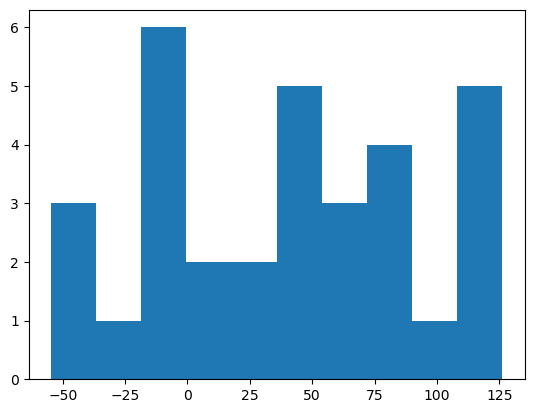

In [32]:
plt.hist(targets)

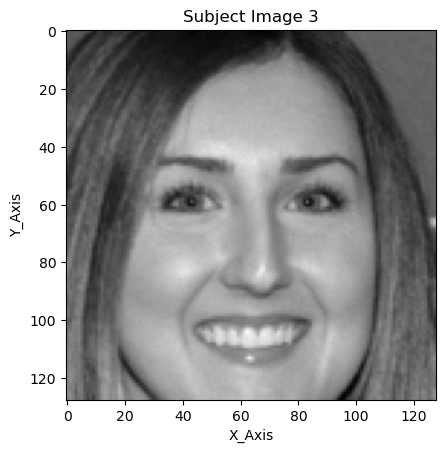

The Target PSNR is: 81.89663


In [33]:
index = 3
plt.imshow(features[index].permute(1, 2, 0).to("cpu").numpy(), cmap = "gray")
plt.xlabel("X_Axis")
plt.ylabel("Y_Axis")
plt.title(f"Subject Image {index}")
plt.show()
print("The Target PSNR is:", targets[index].to("cpu").numpy())

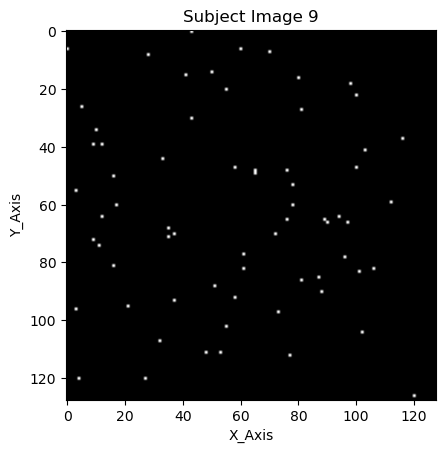

The Target PSNR is: -44.489952


In [ ]:
index = 9
plt.imshow(features[index].permute(1, 2, 0).to("cpu").numpy(), cmap = "gray")
plt.xlabel("X_Axis")
plt.ylabel("Y_Axis")
plt.title(f"Subject Image {index}")
plt.show()
print("The Target PSNR is:", targets[index].to("cpu").numpy())

In [76]:
Predictions = Dense_ConvNet.predict(features.to(device))
Mean_Predictions, Std_Predictions = Predictions
Mean_Predictions.shape, Std_Predictions.shape

(torch.Size([32, 1]), torch.Size([32, 1]))

In [78]:
# Set up the training loop for the model
Early_Stopping = EarlyStopping(monitor = "Validation_Loss", patience = 15, mode = "min")
Model_Checkpoint = ModelCheckpoint(monitor = "Validation_Loss", save_top_k = 1, mode = "min", save_weights_only = True)
Learning_Rate_Monitor = LearningRateMonitor(logging_interval = "step")
Tensorboard_Logger = TensorBoardLogger("Lightning_logs", name = "Possion_AE")
Max_Epochs = 100

name = "Convolutional_ResNet"
CHECKPOINT_PATH = './models/'
Trainer = pL.Trainer(default_root_dir=os.path.join(CHECKPOINT_PATH, name), gradient_clip_val=10,
                     max_epochs=Max_Epochs, accelerator = "gpu", logger=Tensorboard_Logger,
                     callbacks=[Model_Checkpoint,
                                Learning_Rate_Monitor,
                                Early_Stopping])

Trainer.fit(Dense_ConvNet, TrainLoader, ValidLoader)
Trainer.save_checkpoint(os.path.join(CHECKPOINT_PATH, name)+'.ckpt')

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\kdarn\anaconda3\envs\GAPGalaxy\Lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "

  | Name    | Type       | Params
---------------------------------------
0 | Encoder | ModuleList | 1.7 M 
1 | Header  | ModuleList | 5.6 M 
2 | Out_3a  | Linear     | 513   
3 | Out_3b  | Linear     | 513   
---------------------------------------
7.2 M     Trainable params
0         Non-trainable params
7.2 M     Total params
28.961    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\kdarn\anaconda3\envs\GAPGalaxy\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:492: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
c:\Users\kdarn\anaconda3\envs\GAPGalaxy\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.
c:\Users\kdarn\anaconda3\envs\GAPGalaxy\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

c:\Users\kdarn\anaconda3\envs\GAPGalaxy\Lib\site-packages\pytorch_lightning\trainer\call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...


: 